In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay
import sys
import importlib
import os

sys.path.append('..')

import src.feature_engineering
import src.preprocessing
importlib.reload(src.feature_engineering)
importlib.reload(src.preprocessing)

from src.preprocessing import TextPreprocessor
from src.feature_engineering import extract_features
from src.models.logistic_reg import train_lr
from src.models.naive_bayes import train_nb
from src.models.svm_classifier import train_svm

# Load and preprocess data
df = pd.read_csv('../data/fake reviews dataset.csv').sample(2000, random_state=42)

# Preprocess text and extract sentiment
preprocessor = TextPreprocessor()
df['cleaned_text'] = df['text_'].apply(preprocessor.clean_text)
df['vader_compound'] = df['text_'].apply(preprocessor.get_vader_score)

# Split data before feature engineering (prevents data leakage)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
y_train = df_train['label']
y_test = df_test['label']

# Extract features (TF-IDF fitted only on training data)
X_train, X_test, tfidf_vec = extract_features(df_train, df_test=df_test)

if X_train.min() < 0 or X_test.min() < 0:
    sentiment_col_idx = X_train.shape[1] - 1
    X_train[:, sentiment_col_idx] = (X_train[:, sentiment_col_idx] + 1.0) / 2.0
    X_test[:, sentiment_col_idx] = (X_test[:, sentiment_col_idx] + 1.0) / 2.0

os.makedirs('figures', exist_ok=True)

# Train Logistic Regression model
model_lr = train_lr(X_train, y_train)
y_pred = model_lr.predict(X_test)

✓ Confusion matrix saved to: figures/cm_lr.png


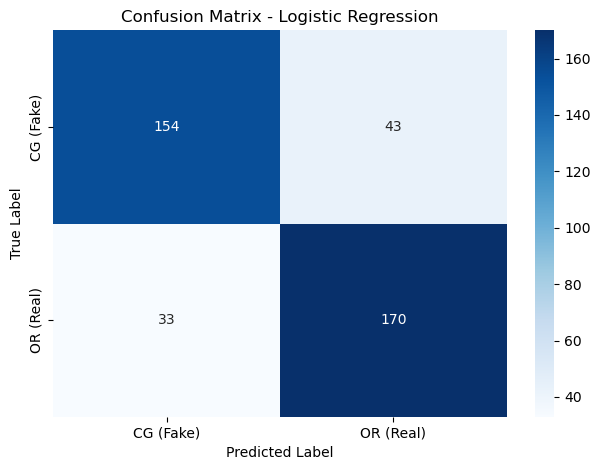

In [6]:
cm = confusion_matrix(y_test, y_pred, labels=['CG', 'OR'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CG (Fake)', 'OR (Real)'], yticklabels=['CG (Fake)', 'OR (Real)'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('figures/cm_lr.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved to: figures/cm_lr.png")
plt.show()

In [ ]:
tfidf_feature_names = tfidf_vec.get_feature_names_out()
tfidf_coef = model_lr.coef_[0][:len(tfidf_feature_names)]

weights = pd.DataFrame({
    'feature': tfidf_feature_names, 
    'weight': tfidf_coef
})

print("Top 10 words indicating a Fake (CG) review:")
print(weights.sort_values(by='weight', ascending=False).head(10))
print("\nTop 10 words indicating a Real (OR) review:")
print(weights.sort_values(by='weight', ascending=True).head(10))

Top 10 words indicating a Fake (CG) review:
        feature    weight
2807       much  2.007545
925       could  1.627354
1325       even  1.563428
1335      every  1.329739
277        back  1.251675
4875  wonderful  1.210212
351      better  1.139416
4862    without  1.095509
1231        end  1.070159
167    anything  1.053910

Top 10 words indicating a Real (OR) review:
          feature    weight
3562       reason -1.970467
2534         love -1.959309
3422      quality -1.856528
373           bit -1.688541
4012        small -1.664911
480        bought -1.524323
799   comfortable -1.492615
3086         pair -1.482756
934        couple -1.472450
4230       sturdy -1.409564
